<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Шаг 1. Загрузка и подготовка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>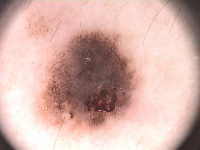</td><td>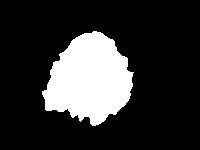</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=000af134-86dd-481a-8e2d-e3669e012360
To: /content/PH2Dataset.rar
100% 162M/162M [00:03<00:00, 49.7MB/s]


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [53]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [54]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [55]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

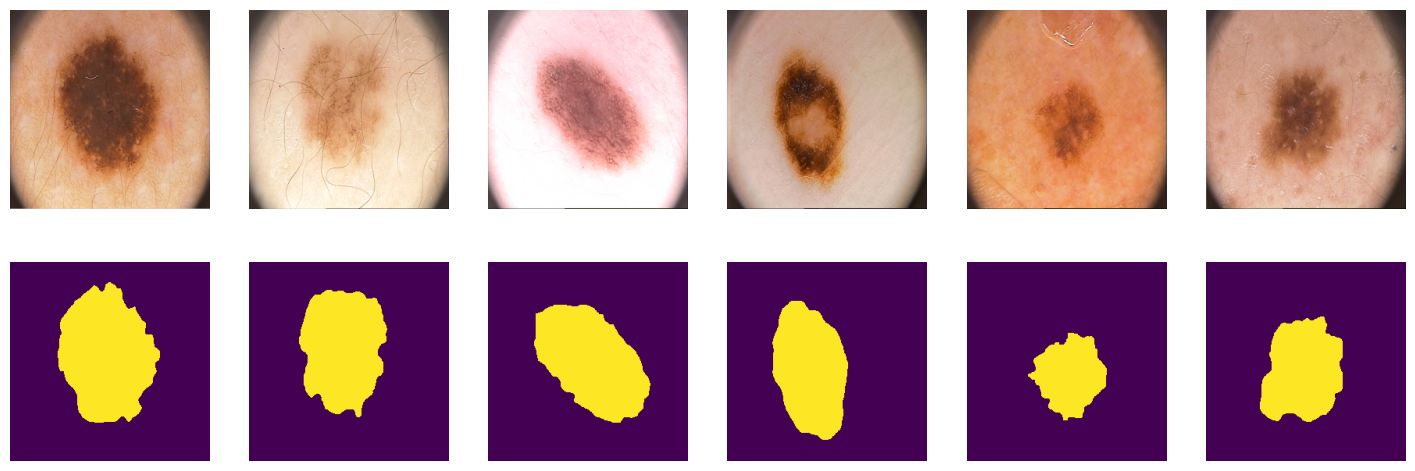

In [58]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [59]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [60]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [61]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [62]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Шаг 2. Метрика качества модели

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [11]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 61.2 MB/s eta 0:00:00


In [12]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Задания: Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## Шаг 3. Loss функция - BCE [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:** $\sigma(\hat{y}) = \frac{1}{1 + e^{-\hat{y}}}$

подставляем сигмоиду и выводим


### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [13]:
import torch.nn.functional as F
import torch.nn as nn

In [14]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def bce_loss(y_pred, y_real):
  return torch.sum(y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred)))

def bce_true(y_pred, y_real):
  return -torch.sum(y_real * np.log(sigmoid(y_pred)) + (1 - y_real) * np.log(1 - sigmoid(y_pred)))

Проверим корректность работы на простом примере

In [16]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss             = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный                = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch              = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch  = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss             = 6.554527282714844
BCE loss честно посчитанный                = 6.554527282714844
BCE loss from torch bce_torch              = 6.554527282714844
BCE loss from torch with logits bce_torch  = 6.554527282714844


/tmp/ipython-input-4258300342.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return torch.sum(y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred)))
/tmp/ipython-input-4258300342.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1 / (1 + np.exp(-x))
/tmp/ipython-input-4258300342.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -torch.sum(y_real * np.log(sigmoid(y_pred)) + (1 - y_real) * np.log(1 - sigmoid(y_pred)))


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

/tmp/ipython-input-4258300342.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return torch.sum(y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred)))
/tmp/ipython-input-4258300342.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1 / (1 + np.exp(-x))
/tmp/ipython-input-4258300342.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -torch.sum(y_real * np.log(sigmoid(y_pred)) + (1 - y_real) * np.log(1 - sigmoid(y_pred)))


Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [18]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss            = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный               = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch             = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss            = 16.10191535949707
BCE loss честно посчитанный               = 16.10191535949707
BCE loss from torch bce_torch             = 16.10191535949707
BCE loss from torch with logits bce_torch = 16.10191535949707


/tmp/ipython-input-4258300342.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return torch.sum(y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred)))
/tmp/ipython-input-4258300342.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1 / (1 + np.exp(-x))
/tmp/ipython-input-4258300342.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -torch.sum(y_real * np.log(sigmoid(y_pred)) + (1 - y_real) * np.log(1 - sigmoid(y_pred)))


In [19]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

/tmp/ipython-input-4258300342.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return torch.sum(y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred)))
/tmp/ipython-input-4258300342.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1 / (1 + np.exp(-x))
/tmp/ipython-input-4258300342.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -torch.sum(y_real * np.log(sigmoid(y_pred)) + (1 - y_real) * np.log(1 - sigmoid(y_pred)))


Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 5.32MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 5.19MB/s]
Download completed


In [21]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

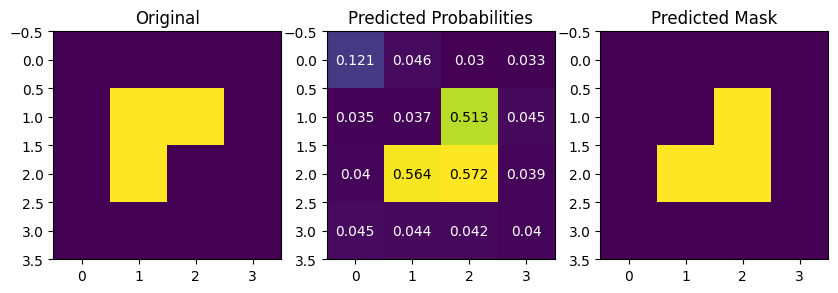

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [23]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

/tmp/ipython-input-4258300342.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return torch.sum(y_pred - y_real * y_pred + np.log(1 + np.exp(-y_pred)))
/tmp/ipython-input-4258300342.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1 / (1 + np.exp(-x))
/tmp/ipython-input-4258300342.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -torch.sum(y_real * np.log(sigmoid(y_pred)) + (1 - y_real) * np.log(1 - sigmoid(y_pred)))


## Шаг 4. Модель SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

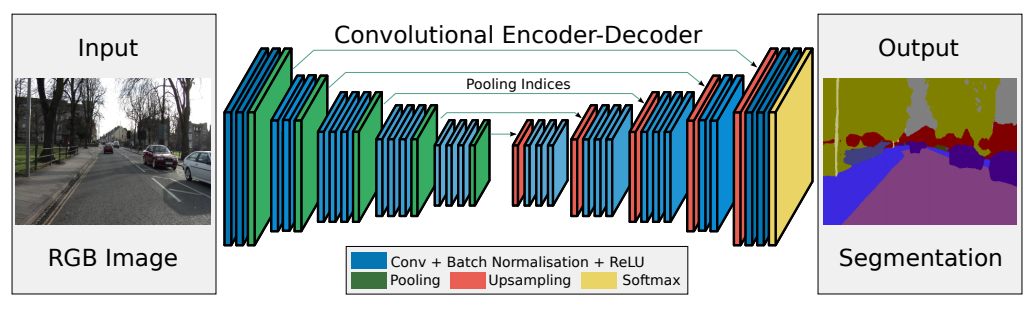

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки. Для этого скачаем и изучим feature extractor VGG-16, который лежит в основе SegNet.

In [25]:
model_vgg16 = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 84.6MB/s]


In [26]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Feature extractor VGG-16 состоит из 5 блоков:
- два блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d
- три блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

В первом блоке - на входе три канала (по числу каналов в изображениях), которые конволюционный слой преобразует в 64 канала.

Во втором, третьем и четвертом блоках первый конволюционный слой удваивает количество каналов, а последующие конволюционные слои не меняют количество каналов.

В последнем блоке число каналов от слоя к слою не меняется.

Теперь напишем код одного блока энкодера нашей модели SegNet.  

In [37]:
# Параметрами блока будут:
# - количество каналов на входе
# - количество каналов на выходе
# - глубина блока (2 или 3, по количеству конволюционных слоев)
# - kernel_size и padding
#
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1):
        super(EncoderBlock, self).__init__() # инициируем экземляр класса, наследующего от nn.Module
        self.layers = nn.ModuleList() # в self.layers будем добавлять слои блока
        # дальше реализуем то, что на картинке выше обозначено Conv + Batch Normalization + ReLU
        self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU(inplace=True))

        # цикл for помогает использовать один код для блоков как с глубиной 2, так и с глубиной 3
        for i in range(depth-1):
            self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) #добавляем MaxPool с индексами для последующего Unpooling

    # Обратите внимание: на вход метод forward() получает карту признаков (х),
    # а возвращает карту признаков и индексы для последующего Unpooling
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, indices = self.maxpooling(x)
        return x, indices


По аналогии напишите код одного блока декодера.

К карте признаков на входе каждого блока примеяется nn.MaxUnpool2d с индексами из симметричного блока энкодера. Затем повторяется связка Conv + Batch Normalization + ReLU. Количество каналов меняется зеркально блокам энкодера:
- в первом блоке декодера количество каналов не меняется
- во 2-4 блоках декодера количество каналов уменьшается в 2 раза после прохождения последнего конволюционного слоя
- на выходе из последнего блока декодера 1 канал

Обратите внимание, что после последней конволюции последнего блока декодера не применяется батч-нормализация и функция активации.

In [82]:
class DecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1):
    super(DecoderBlock, self).__init__()
    self.layers = nn.ModuleList()
    self.maxUnpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

    self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding))
    self.layers.append(nn.BatchNorm2d(out_channels))
    self.layers.append(nn.ReLU(inplace=True))

    for _ in range(depth-1):
        self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU(inplace=True))

  def forward(self, x, indices):
    x = self.maxUnpool(x, indices)
    for layer in self.layers:
      x = layer(x)
    return x


Соединим блоки энкодера и декодера в модель SegNet:

In [111]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels = 1, num_features = 64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.encoder0 = EncoderBlock(in_channels, num_features, depth=2)
        self.encoder1 = EncoderBlock(num_features, num_features * 2, depth=2)
        self.encoder2 = EncoderBlock(num_features * 2, num_features * 4, depth=2)
        self.encoder3 = EncoderBlock(num_features * 4, num_features * 8, depth=2)

        # Encoder bottleneck - количество каналов на входе и на выходе одинаково
        self.encoder4 = EncoderBlock(num_features * 8, num_features * 8, depth=2)

        # Decoder bottleneck
        self.decoder4 = DecoderBlock(num_features * 8, num_features * 8, depth=2)

        # Decoder
        self.decoder3 = DecoderBlock(num_features * 8, num_features * 4, depth=2)
        self.decoder2 = DecoderBlock(num_features * 4, num_features * 2, depth=2)
        self.decoder1 = DecoderBlock(num_features * 2, num_features, depth=2)
        self.decoder0 = DecoderBlock(num_features, out_channels, depth=2)

    def forward(self, x):
        # encoder
        x, indices0 = self.encoder0(x)
        x, indices1 = self.encoder1(x)
        x, indices2 = self.encoder2(x)
        x, indices3 = self.encoder3(x)
        x, indices4 = self.encoder4(x)
        # TODO
        output = self.decoder4(x, indices4)
        output = self.decoder3(output, indices3)
        output = self.decoder2(output, indices2)
        output = self.decoder1(output, indices1)
        output = self.decoder0(output, indices0)
        return output  # no activation

## Шаг 5. Тренировка модели [1 балл]

Напишите функции для обучения модели.

In [112]:
from tqdm.notebook import tqdm

In [113]:
segNet = SegNet(in_channels=3, out_channels=1, num_features=64)
segNet.to(device)
optim = torch.optim.Adam(segNet.parameters())

In [114]:
def train(model, optim, criterion, dataloader, device, iou=None):
  model.train()
  losses = []
  for X_batch, y_batch in tqdm(dataloader):
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    optim.zero_grad()
    y_pred = model(X_batch)
    loss = criterion(y_pred, y_batch)
    losses.append(loss.item())
    loss.backward()
    optim.step()
    if iou is not None:
      iou.update(torch.sigmoid(y_pred), y_batch.long())
  if iou is not None:
      iou_value = iou.compute().item()
      iou.reset()
  else:
      iou_value = None
  avg_loss = np.mean(losses)
  return avg_loss, iou_value

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [115]:
EPOCHES = 100
losses = []
iou_scores = []
print('-----START TRAINING-----')
for epoch in range(1, EPOCHES+1):
   avg_loss, iou_value = train(segNet, optim, bce_torch_with_logits, train_dataloader, device, iou=iou_score)
   print(f'EPOCH: {epoch} | avg_loss: {avg_loss} | iou_value: {iou_value}')
   losses.append(avg_loss)
   iou_scores.append(iou_value)
print('-----END OF TRAINING-----')

-----START TRAINING-----


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 1 | avg_loss: 1196675.96875 | iou_value: 0.25432536005973816


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 2 | avg_loss: 1127513.34375 | iou_value: 0.2701811194419861


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 3 | avg_loss: 1114805.75 | iou_value: 0.23163209855556488


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 4 | avg_loss: 1102829.28125 | iou_value: 0.19231222569942474


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 5 | avg_loss: 1099820.625 | iou_value: 0.1939122974872589


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 6 | avg_loss: 1086968.71875 | iou_value: 0.231093630194664


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 7 | avg_loss: 1062519.65625 | iou_value: 0.3435957729816437


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 8 | avg_loss: 1060221.203125 | iou_value: 0.3480333089828491


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 9 | avg_loss: 1051294.40625 | iou_value: 0.3550812304019928


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 10 | avg_loss: 1048921.765625 | iou_value: 0.37125611305236816


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 11 | avg_loss: 1049446.75 | iou_value: 0.3769380450248718


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 12 | avg_loss: 1046449.484375 | iou_value: 0.3678481876850128


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 13 | avg_loss: 1046677.1875 | iou_value: 0.3748696744441986


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 14 | avg_loss: 1046587.234375 | iou_value: 0.3801763653755188


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 15 | avg_loss: 1040131.25 | iou_value: 0.3914322555065155


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 16 | avg_loss: 1041630.6875 | iou_value: 0.40493711829185486


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 17 | avg_loss: 1040765.125 | iou_value: 0.3894988000392914


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 18 | avg_loss: 1036724.078125 | iou_value: 0.39596909284591675


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 19 | avg_loss: 1034740.75 | iou_value: 0.4118291437625885


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 20 | avg_loss: 1035365.8125 | iou_value: 0.41170385479927063


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 21 | avg_loss: 1034706.96875 | iou_value: 0.3961580693721771


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 22 | avg_loss: 1035670.0 | iou_value: 0.40855228900909424


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 23 | avg_loss: 1036517.59375 | iou_value: 0.4072088599205017


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 24 | avg_loss: 1032672.0 | iou_value: 0.3984035849571228


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 25 | avg_loss: 1039246.3125 | iou_value: 0.40693584084510803


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 26 | avg_loss: 1027659.40625 | iou_value: 0.415659636259079


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 27 | avg_loss: 1027264.140625 | iou_value: 0.4254995286464691


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 28 | avg_loss: 1025365.140625 | iou_value: 0.42404839396476746


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 29 | avg_loss: 1028001.09375 | iou_value: 0.4181930124759674


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 30 | avg_loss: 1029333.625 | iou_value: 0.4055843949317932


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 31 | avg_loss: 1030673.671875 | iou_value: 0.40672174096107483


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 32 | avg_loss: 1028682.734375 | iou_value: 0.4093925952911377


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 33 | avg_loss: 1027713.671875 | iou_value: 0.4107688069343567


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 34 | avg_loss: 1020798.4375 | iou_value: 0.4287930130958557


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 35 | avg_loss: 1026707.625 | iou_value: 0.4277869462966919


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 36 | avg_loss: 1026021.0625 | iou_value: 0.41024652123451233


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 37 | avg_loss: 1026635.953125 | iou_value: 0.40952643752098083


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 38 | avg_loss: 1026942.296875 | iou_value: 0.415915846824646


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 39 | avg_loss: 1025830.84375 | iou_value: 0.41647836565971375


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 40 | avg_loss: 1029315.9375 | iou_value: 0.40664905309677124


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 41 | avg_loss: 1019885.703125 | iou_value: 0.4290286898612976


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 42 | avg_loss: 1022313.921875 | iou_value: 0.4265111982822418


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 43 | avg_loss: 1018039.109375 | iou_value: 0.4334869682788849


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 44 | avg_loss: 1018441.3125 | iou_value: 0.43488913774490356


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 45 | avg_loss: 1018170.28125 | iou_value: 0.4258357882499695


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 46 | avg_loss: 1014949.90625 | iou_value: 0.4426092505455017


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 47 | avg_loss: 1013502.578125 | iou_value: 0.4570893347263336


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 48 | avg_loss: 1006665.203125 | iou_value: 0.5025631189346313


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 49 | avg_loss: 982523.03125 | iou_value: 0.6297593712806702


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 50 | avg_loss: 964420.03125 | iou_value: 0.7404118180274963


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 51 | avg_loss: 963276.84375 | iou_value: 0.6654536128044128


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 52 | avg_loss: 940690.390625 | iou_value: 0.7734240293502808


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 53 | avg_loss: 933235.171875 | iou_value: 0.8025704622268677


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 54 | avg_loss: 948988.125 | iou_value: 0.7955271005630493


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 55 | avg_loss: 940221.34375 | iou_value: 0.7667605876922607


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 56 | avg_loss: 924220.328125 | iou_value: 0.8240863084793091


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 57 | avg_loss: 931554.40625 | iou_value: 0.8091567754745483


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 58 | avg_loss: 923168.125 | iou_value: 0.8114169836044312


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 59 | avg_loss: 920963.921875 | iou_value: 0.8381077647209167


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 60 | avg_loss: 934289.765625 | iou_value: 0.7862407565116882


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 61 | avg_loss: 932631.8125 | iou_value: 0.7814334034919739


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 62 | avg_loss: 923753.0 | iou_value: 0.8096840381622314


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 63 | avg_loss: 920450.375 | iou_value: 0.8210763335227966


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 64 | avg_loss: 910940.28125 | iou_value: 0.8504968285560608


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 65 | avg_loss: 908365.421875 | iou_value: 0.8621924519538879


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 66 | avg_loss: 921845.03125 | iou_value: 0.8233934044837952


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 67 | avg_loss: 915004.234375 | iou_value: 0.8274892568588257


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 68 | avg_loss: 909348.90625 | iou_value: 0.8536754250526428


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 69 | avg_loss: 907927.421875 | iou_value: 0.8470487594604492


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 70 | avg_loss: 907389.28125 | iou_value: 0.8500833511352539


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 71 | avg_loss: 904249.09375 | iou_value: 0.870342493057251


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 72 | avg_loss: 903658.484375 | iou_value: 0.8548863530158997


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 73 | avg_loss: 927387.671875 | iou_value: 0.817891001701355


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 74 | avg_loss: 916468.84375 | iou_value: 0.8085618615150452


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 75 | avg_loss: 907297.578125 | iou_value: 0.8464063405990601


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 76 | avg_loss: 910874.625 | iou_value: 0.8432148694992065


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 77 | avg_loss: 905906.078125 | iou_value: 0.8430995345115662


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 78 | avg_loss: 904839.265625 | iou_value: 0.8512131571769714


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 79 | avg_loss: 907546.5 | iou_value: 0.8524703979492188


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 80 | avg_loss: 899275.1875 | iou_value: 0.8632027506828308


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 81 | avg_loss: 901807.4375 | iou_value: 0.8522995114326477


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 82 | avg_loss: 904339.390625 | iou_value: 0.8530276417732239


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 83 | avg_loss: 895531.734375 | iou_value: 0.8699329495429993


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 84 | avg_loss: 893372.25 | iou_value: 0.8726736903190613


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 85 | avg_loss: 887972.78125 | iou_value: 0.8913894295692444


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 86 | avg_loss: 891800.984375 | iou_value: 0.8811765909194946


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 87 | avg_loss: 889409.75 | iou_value: 0.886494517326355


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 88 | avg_loss: 888226.171875 | iou_value: 0.8898023962974548


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 89 | avg_loss: 886467.6875 | iou_value: 0.8877764940261841


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 90 | avg_loss: 883482.34375 | iou_value: 0.8979019522666931


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 91 | avg_loss: 884541.6875 | iou_value: 0.8989824056625366


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 92 | avg_loss: 899181.28125 | iou_value: 0.86039137840271


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 93 | avg_loss: 899973.546875 | iou_value: 0.8296206593513489


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 94 | avg_loss: 892862.984375 | iou_value: 0.8752329349517822


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 95 | avg_loss: 888028.859375 | iou_value: 0.8869741559028625


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 96 | avg_loss: 882694.6875 | iou_value: 0.8908184170722961


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 97 | avg_loss: 882909.875 | iou_value: 0.8926949501037598


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 98 | avg_loss: 891906.734375 | iou_value: 0.8756135106086731


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 99 | avg_loss: 897428.0 | iou_value: 0.8474987149238586


  0%|          | 0/4 [00:00<?, ?it/s]

EPOCH: 100 | avg_loss: 889859.265625 | iou_value: 0.8640511631965637
-----END OF TRAINING-----


## Шаг 6. Инференс [1 балл]

После обучения модели напишите функцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [117]:
def test(model, optim, criterion, dataloader, device, iou=None):
  model.eval()
  losses = []
  with torch.no_grad():
    for X_batch, y_batch in tqdm(dataloader):
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      y_pred = model(X_batch)
      loss = criterion(y_pred, y_batch)
      losses.append(loss.item())
      if iou is not None:
        iou.update(torch.sigmoid(y_pred), y_batch.long())
  if iou is not None:
      iou_value = iou.compute().item()
      iou.reset()
  else:
      iou_value = None
  avg_loss = np.mean(losses)
  return avg_loss, iou_value

In [118]:
test(segNet, optim, bce_torch_with_logits, valid_dataloader, device, iou=iou_score)

  0%|          | 0/2 [00:00<?, ?it/s]

(np.float64(913420.03125), 0.7471134662628174)

# Задания: Мир других лоссов!

## Пробуем другие функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    # TODO

    return score

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667)

In [ ]:
'''
если вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():

from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)

'''

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    # TODO

    return loss

Проверка на корректность:

In [ ]:
# проверьте, что у вас установлена библиотека
#!pip install segmentation-models-pytorch

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    # TODO

    return loss

Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

In [ ]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



# Задание: Новая модель!

## Модель U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

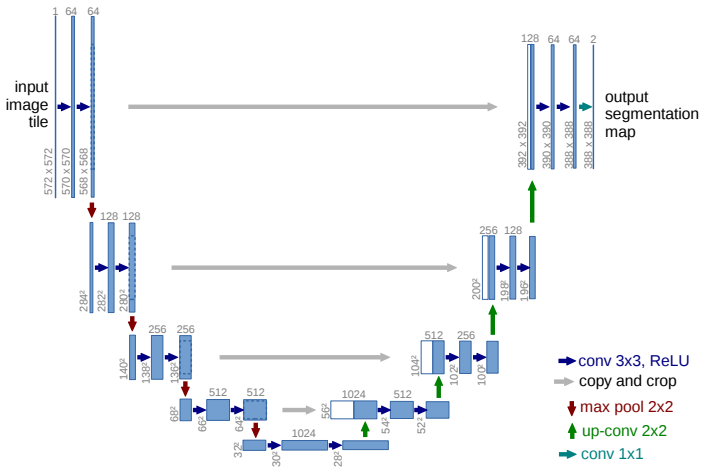

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

В оригинальной статье авторы не использовали padding внутри модели (это видно по тому, что размеры карты признаков уменьшаются на 2 каждый раз при движении от слоя к слою). При этом размеры входных изображений авторы единоразово увеличили при помощи mirror padding.

В этом домашнем задании вы можете применить альтернативный подход - сохранять размеры карт признаков при помощью padding = 1 во внутренних слоях.  

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

Для реализации UNet вы можете написать классы блоков энкодера и декодера отдельно, как мы сделали при реализации SegNet.

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # TODO

    def forward(self, x):
        #  TODO

        return output

In [ ]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.

